<a href="https://colab.research.google.com/github/klopetx/PHM_tutorial/blob/main/src/02.A_Feature_Extraction_I_time_domain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

project_path = 'PHM_tutorial'

if not os.path.isdir(project_path):

  username = 'klopetx'
  repo = project_path

  !git clone https://@github.com/{username}/{repo}

os.chdir(project_path)

!python src/00_Environment_Checks.py


FEMTO dataset is already downloaded.


# Feature extraction

We just saw how ward it is to obtain meaningfull informaton from raw signals.
That is why we try to characterize them by using indicators/features/kpis so that we can summarise the content of the signal into meaningful data that represent how the signals behaves.

One way of doing that is adding some "simple" statistical descriptors. These descriptors will try to represent the whole signal in different values that represent some behaviours of the signals.

In order to validate that the feature extraction is behaving as expected, we will create a small sandbox, that is, a controlled scenario in which we can easily validate the outcomes of the signal processing (because we can compute it by hand).

In [2]:
import pandas as pd
import numpy as np
import sys
sys.path.append('src')
import auxiliars as aux

## A sandbox for time domain feature extraction

By using a small dummy dataset, we can validate the features we are willing to extract.

Let's create the dataset:

In [3]:
# Create a small dataset for validation
data = {
    'file_name': ['file1.csv', 'file1.csv', 'file2.csv', 'file2.csv', 'file3.csv'],
    'column1': [1, 2, 3, 4, 5],
    'column2': [5, 4, 3, 2, 1]
}

df2 = pd.DataFrame(data)
print(df2)


   file_name  column1  column2
0  file1.csv        1        5
1  file1.csv        2        4
2  file2.csv        3        3
3  file2.csv        4        2
4  file3.csv        5        1


Once we have the dataset, we can create signal extraction functions:




In [4]:
# Defining a "more complex" indicator
def calculate_crest_factor(x):
    peak_value = x.abs().max()
    rms = np.sqrt(np.mean(x**2))
    return peak_value / rms

# Defining all indicators to be extracted
indicators = {
    'max': lambda x: x.max(),
    'min': lambda x: x.min(),
    'sum_abs': lambda x: x.abs().sum(),
    'rms': lambda x: np.sqrt(np.mean(x**2)),
    'crest_factor': calculate_crest_factor
}


Finally, we can validate if the values of the indicators are correct:

In [5]:
aux.compute_features(df2,2, indicators)

,file_name,max,min,sum_abs,rms,crest_factor
0,file1.csv,5.0,4.0,9.0,4.527693,1.104315
1,file2.csv,3.0,2.0,5.0,2.549510,1.176697
2,file3.csv,1.0,1.0,1.0,1.000000,1.000000


### Exercise

1) Would you be able to extract a new indicator from the ones visible on the slides? Modify the previous code.



# Extracting features through the life of a Bearing

Now that we have a bunch of time domain features to be extracted, lets see what happens when we visualize the life of a bearing according to time domain indicators.
What we want to see is how a particular feature of the raw signals has evolved over time.

## Vibrations

We will analyse how the vibration indicators evolve over time.

For doins so, we need to:

1) Load some (all are too many) of the raw signals of a bearing

2) Extract the features on each signal

3) Visualize the indicators chronologically



### 1) Data loading

We will select a Bearing folder and a prefix (file_prefix) to filter the kind of file we want to open. Given that there are lots of readings, we will only read one in every X (the one_in variable) which will skip the intermediate files. This is done because, right now, we only want to have a look not to extract absolutely all the files.

In [6]:
path = "/content/PHM_tutorial/data/10. FEMTO Bearing/Learning_set/Bearing2_1"

file_prefix = 'acc_'

one_in = 50  # Change as needed to read every second, third, etc., file

vibrationDF = aux.concatenate_files(path, file_prefix, one_in, True)

vibrationDF.head()

Total number of listed files with prefix 'acc_': 911
Number of files read (based on one_in=50): 19


,0,1,2,3,4,5,OP_Condition,OPC_Test_Number,Test_Index,file_name
0,8,14,15,884410.0,-0.391,0.011,2,1,1,/content/PHM_tutorial/data/10. FEMTO Bearing/L...
1,8,14,15,884450.0,0.292,0.133,2,1,1,/content/PHM_tutorial/data/10. FEMTO Bearing/L...
2,8,14,15,884490.0,0.596,0.024,2,1,1,/content/PHM_tutorial/data/10. FEMTO Bearing/L...
3,8,14,15,884530.0,0.230,0.272,2,1,1,/content/PHM_tutorial/data/10. FEMTO Bearing/L...
4,8,14,15,884570.0,-0.225,0.272,2,1,1,/content/PHM_tutorial/data/10. FEMTO Bearing/L...


### 2) Feature extraction

As we already created some functions to extract indicators, we will apply those feature extraction functions to the new dataset.

In [7]:
vibrationKPI = aux.compute_features(vibrationDF, 5, indicators, True)

In [8]:
vibrationKPI.head()

,file_name,max,min,sum_abs,rms,crest_factor,OP_Condition,OPC_Test_Number,Bearing,Test_Index
0,/content/PHM_tutorial/data/10. FEMTO Bearing/L...,0.861,-1.040,541.186,0.262582,3.960663,2,1,Bearing2_1,1
1,/content/PHM_tutorial/data/10. FEMTO Bearing/L...,1.028,-1.143,619.139,0.301586,3.789964,2,1,Bearing2_1,51
2,/content/PHM_tutorial/data/10. FEMTO Bearing/L...,1.061,-0.958,510.259,0.251626,4.216578,2,1,Bearing2_1,101
3,/content/PHM_tutorial/data/10. FEMTO Bearing/L...,2.493,-2.172,1017.155,0.520092,4.793384,2,1,Bearing2_1,151
4,/content/PHM_tutorial/data/10. FEMTO Bearing/L...,3.160,-2.940,1542.873,0.774481,4.080150,2,1,Bearing2_1,201


### 3) Bearing data evolution

Let's see what these indicators have!

In [9]:
import matplotlib.pyplot as plt

def plot_indicator(df, x_column, y_column):
    """
    Plot a indicator from a DataFrame using the specified columns for the X and Y axes.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data to plot.
    - x_column (str): The name of the column to use for the X-axis.
    - y_column (str): The name of the column to use for the Y-axis.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(df[x_column], df[y_column], label=y_column)
    plt.title(f'{y_column} indicator Over {x_column}')
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    plt.legend()
    plt.grid(True)
    plt.show()

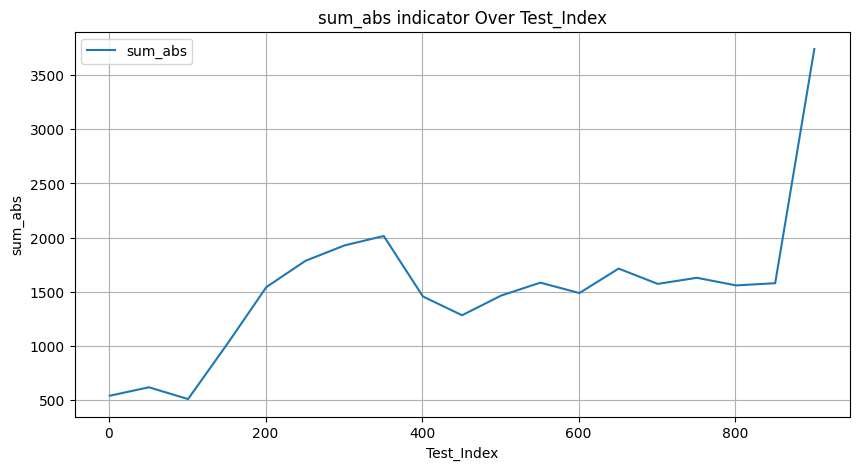

In [10]:
plot_indicator(vibrationKPI, 'Test_Index', 'sum_abs')

## Exercises

2) Plot another all the remaining indicators, which one does seem to be better?

3) Repliclate the previous extraction for another bearing.

4) Replicate the previous extraction for temperature signals.

## Submission

Ensure the notebook runs from top to bottom before submitting it.